In [6]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution


%load_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

## Shared functions

In [73]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack', process_cohorts=False):
    # method: PCA
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    ind = df.index
    red_data_dict = {}
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, :]
    X_red = reducer.fit_transform(X)
    
    red_cols = ['red_'+str(i) for i in range(0,n_comp)]
    df_red = pd.DataFrame(data=X_red, index=ind, columns=red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df_red
    red_data_dict['ALL']['reducer'] = reducer
    
    return red_data_dict

In [8]:
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

# significances of differences between pheno's.
def distribution_difference_phenotypes(df, batches=[], phenotypes=[]):
    tot_res = []
    for _phenotype in phenotypes:    
        res = []
        for _batch_nr in batches:
            _all = df.loc[df.batch_number!=_batch_nr][_phenotype]
            _batch = df.loc[df.batch_number==_batch_nr][_phenotype]
            _ks = ks2(_all.values, _batch.values)
            _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
            try:
                _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
                _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            except ValueError as e:
                print('ValError, defaulting to NaN')
                _w1 = _w2 = np.nan

            res.append({'batch_number': _batch_nr,
                        'ks_stat': _ks[0], 'ks_p': _ks[1],
                        'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                        'w1_dist': _w1, 'w2_dist': _w2})
        res_df = pd.DataFrame(res)
        tot_res.append({_phenotype: res_df})
    return tot_res

def _cohort_bias_metrics_colwise_reduced(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


In [9]:
#@jit
def median_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        median_batch = np.median(x[:, batch_ids[_batch]], axis=1)
        #median_all = np.median(x, axis=1)
        median_all = np.median(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = median_batch - median_all
        
    return delta 

@jit
def mean_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        mean_batch = np.mean(x[:, batch_ids[_batch]], axis=1)
        #mean_all = np.mean(x, axis=1)
        mean_all = np.mean(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = mean_batch - mean_all
        
    return delta 

## Load data
Due to resources limitations we analysis one methylation set at a time. 

In [10]:
# "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung"
# "/home/bramiozo/DATA/LungCancerResearch/" 
source_dir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/"

Meth_Raw = pd.read_csv(source_dir+"Lung_Methylation.txt", sep="\t", engine="python")

Meth_Raw.set_index('probeID', inplace=True)
GeneMapping = Meth_Raw[['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
Meth_Raw.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], inplace=True, axis=1)

In [11]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']

In [12]:
methylation_meta = pd.read_csv(source_dir+"HumanMethylation450_meta.csv", sep=",", engine="python", skiprows=7)

In [13]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic
pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [15]:
# split by diagnosis
LA_samples = pheno.loc[pheno.Diagnosis=='Lung Adenocarcinoma'].index.values
LSCC_samples = pheno.loc[pheno.Diagnosis=='Lung Squamous Cell Carcinoma'].index.values

In [16]:
# to check for cohort bias we only use the reference probe initially
gc.collect()  

51

In [27]:
Meth_data = {'LA': Meth_Raw.loc[:, LA_samples],
             'LSCC': Meth_Raw.loc[:, LSCC_samples]}
del Meth_Raw

gc.collect()

Meth_data_T = {'LA': Meth_data['LA'].T, 
               'LSCC': Meth_data['LSCC'].T}

1023

### Seperability of cohorts

In [107]:
def _clean(df, complete=True):
    drop_rows = df[df.isna().sum(axis=1)>450000].index.tolist()
    drop_cols = df.columns[df.isna().sum(axis=0)>400].tolist()
    print("We drop {} samples and {} probes".format(len(drop_rows), len(drop_cols)))
    df_out = df.copy().drop(drop_rows, axis=0).drop(drop_cols, axis=1)
    if complete:
        drop_cols = df_out.copy().columns[df_out.copy().isna().sum(axis=0)>0].tolist()
        df_out = df_out.copy().drop(drop_cols, axis=1)
    initial_points = df.shape[0]*df.shape[1]
    removed = (initial_points - df_out.shape[0]*df_out.shape[1])
    print("Removed {} points from an initial {} points".format(removed, initial_points))
    return df_out

In [125]:
_cleaned_LA = _clean(Meth_data_T['LA'])
_cleaned_LSCC = _clean(Meth_data_T['LSCC'])

We drop 0 samples and 0 probes
Removed 12237684 points from an initial 194467915 points
We drop 134 samples and 89512 probes
Removed 103868270 points from an initial 246187539 points


In [106]:
gc.collect()
data_reduced = {}
data_reduced['LA'] = _dim_reduction(_cleaned_LA, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack')
data_reduced['LSCC'] = _dim_reduction(_cleaned_LSCC, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack')

We drop 0 samples and 0 probes
Running reducer on all samples..
We drop 134 samples and 89512 probes
Running reducer on all samples..


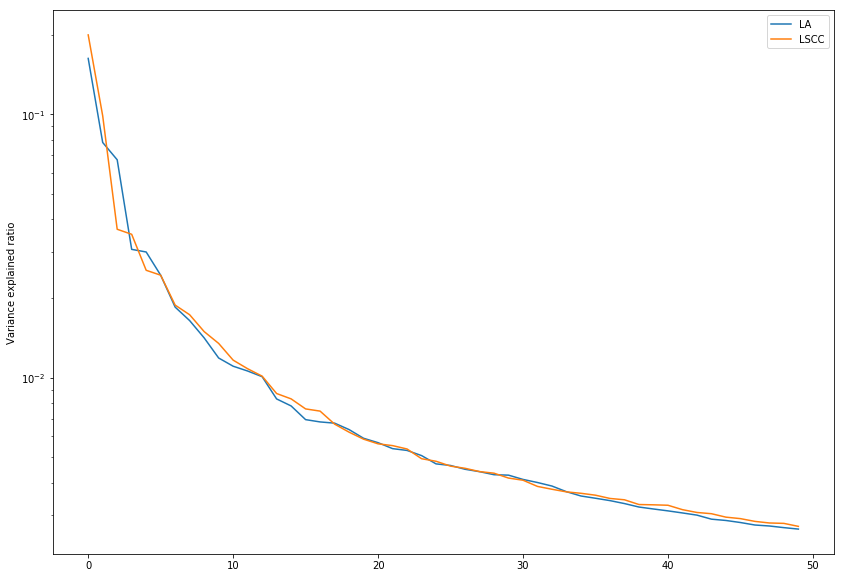

In [108]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

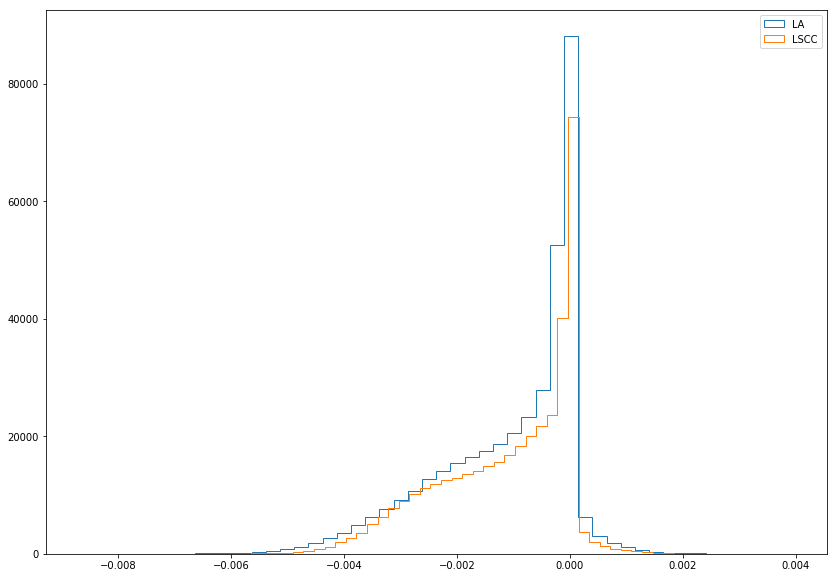

In [132]:
fig, ax = plt.subplots(figsize=(14,10))
plt.hist(data_reduced['LA']['ALL']['reducer'].components_[0], bins=50, histtype='step', label='LA');
plt.hist(data_reduced['LSCC']['ALL']['reducer'].components_[0], bins=50, histtype='step', label='LSCC');
plt.legend()

In [126]:
_filter= (data_reduced['LA']['ALL']['reducer'].components_[0]>0.001) | \
         (data_reduced['LA']['ALL']['reducer'].components_[0]<-0.004)
pca_0_idx = np.argwhere(_filter)
Genes = _cleaned_LA.columns[pca_0_idx]
print("Important genes are for the first principal component: \n {}".format(Genes))

Important genes are for the first principal component: 
 Index(['cg00001583', 'cg00001747', 'cg00007426', 'cg00011616', 'cg00012529',
       'cg00013015', 'cg00016127', 'cg00019118', 'cg00020799', 'cg00021242',
       ...
       'cg27648858', 'cg27650175', 'cg27651090', 'cg27652681', 'cg27655954',
       'cg27657537', 'cg27664085', 'rs10033147', 'rs2385226', 'rs6991394'],
      dtype='object', name='probeID', length=11584)


In [135]:
pheno.columns

Index(['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis',
       'Age At Diagnosis (Days)', 'batch_number', 'histological_type',
       'cigarettes_per_day.exposures', 'tissue_or_organ_of_origin.diagnoses',
       'race.demographic'],
      dtype='object')

In [155]:
# Clustering of cohorts
data_reduced['LA']['ALL']['data'] = data_reduced['LA']['ALL']['data'][~data_reduced['LA']['ALL']['data'].index.duplicated(keep='first')]
data_reduced['LSCC']['ALL']['data'] = data_reduced['LSCC']['ALL']['data'][~data_reduced['LSCC']['ALL']['data'].index.duplicated(keep='first')]

merged_LA_reduced = data_reduced['LA']['ALL']['data'].merge(pheno, how='left', left_index=True, right_index=True)
merged_LSCC_reduced = data_reduced['LSCC']['ALL']['data'].merge(pheno, how='left', left_index=True, right_index=True)

Text(0.5,0.98,'Mean methylation PC values per cohort')

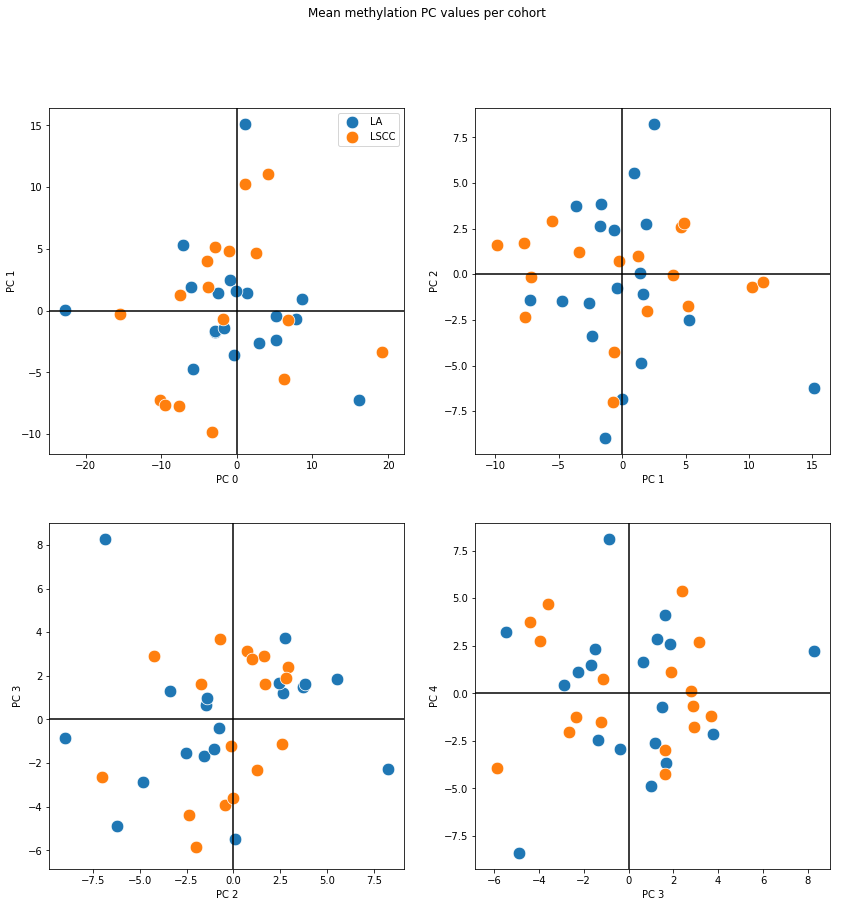

In [210]:
red_cols = [_col for _col in merged_LA_reduced.columns if 'red_' in _col]
red_cols += ['batch_number'] 
plot_LA = merged_LA_reduced[red_cols].groupby('batch_number').mean()

red_cols = [_col for _col in merged_LA_reduced.columns if 'red_' in _col]
red_cols += ['batch_number'] 
plot_LSCC = merged_LSCC_reduced[red_cols].groupby('batch_number').mean()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,14))
sns.scatterplot(data=plot_LA, x='red_0', y='red_1', s=160, label='LA', ax=ax[0,0])
sns.scatterplot(data=plot_LSCC, x='red_0', y='red_1', s=160, label='LSCC', ax=ax[0,0])
ax[0,0].set_xlabel('PC 0')
ax[0,0].set_ylabel('PC 1')
ax[0,0].legend()
ax[0,0].axvline(0, color='black')
ax[0,0].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_1', y='red_2', s=160, ax=ax[0,1])
sns.scatterplot(data=plot_LSCC, x='red_1', y='red_2', s=160, ax=ax[0,1])
ax[0,1].set_xlabel('PC 1')
ax[0,1].set_ylabel('PC 2')
ax[0,1].axvline(0, color='black')
ax[0,1].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_2', y='red_3', s=160, ax=ax[1,0])
sns.scatterplot(data=plot_LSCC, x='red_2', y='red_3', s=160, ax=ax[1,0])
ax[1,0].set_xlabel('PC 2')
ax[1,0].set_ylabel('PC 3')
ax[1,0].axvline(0, color='black')
ax[1,0].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_3', y='red_4', s=160, ax=ax[1,1])
sns.scatterplot(data=plot_LSCC, x='red_3', y='red_4', s=160, ax=ax[1,1])
ax[1,1].set_xlabel('PC 3')
ax[1,1].set_ylabel('PC 4')
ax[1,1].axvline(0, color='black')
ax[1,1].axhline(0, color='black')


plt.suptitle('Mean methylation PC values per cohort')

The cohort means for the first principle components are distributed around the origin, so assuming an equal sample contribution per cohort the overall 
effect is likely diffuse.


# Batch seperability

In [190]:
data_reduced['LA']['ALL']['data'] = merged_LA_reduced
data_reduced['LSCC']['ALL']['data'] = merged_LSCC_reduced

Processing ds: LA
Processing ds: LSCC


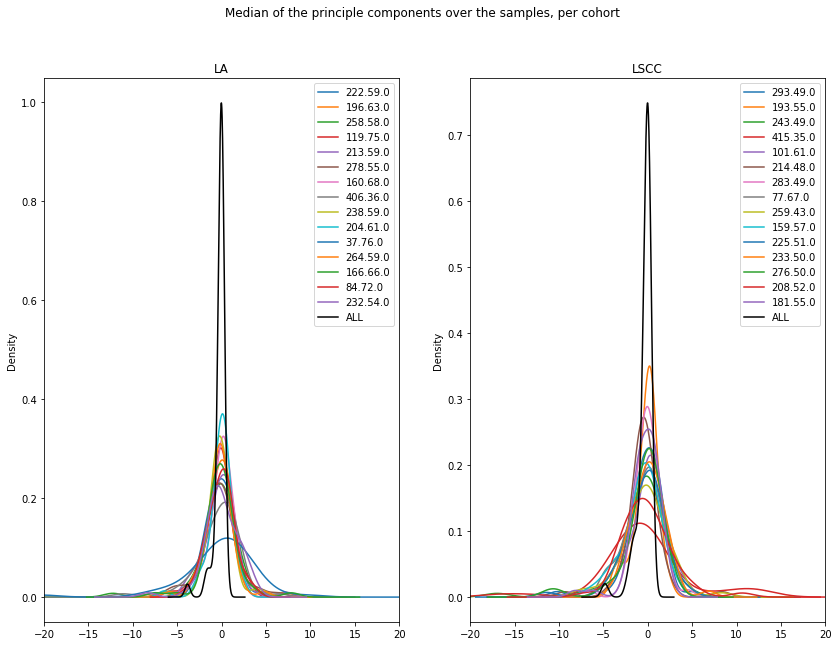

In [218]:
num_test_batches = 15
test_batches = {}

num_of_batches=data_reduced['LA']['ALL']['data']['batch_number'].nunique()
batches = data_reduced['LA']['ALL']['data']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches['LA'] = batches[batch_indices].tolist()

num_of_batches=data_reduced['LSCC']['ALL']['data']['batch_number'].nunique()
batches = data_reduced['LSCC']['ALL']['data']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches['LSCC'] = batches[batch_indices].tolist()

axc = 0 # 0: distribution of the mean probe values over the samples, 1: mean sample values over the probes
xr = -20, 20
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for rdx, _dkey in enumerate(data_reduced.keys()):   
    print("Processing ds: {}".format(_dkey))
    for cdx, _batch in enumerate(test_batches[_dkey]):
        #print('Batch: {}'.format(_batch))
        Red_columns = [_col for _col in data_reduced[_dkey]['ALL']['data'].columns if 'red_' in _col]
        data_reduced[_dkey]['ALL']['data'].query('batch_number=="'+str(_batch)+'"').loc[:,Red_columns]\
                                                                     .median(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rdx])            
    
    data_reduced[_dkey]['ALL']['data'].loc[:,Red_columns].median(axis=0).plot.kde(label='ALL', color='black', ax=ax[rdx])
    ax[rdx].set_xlim(xr[0], xr[1])
    ax[rdx].set_title(_dkey)
    ax[rdx].legend()
    fig.suptitle('Median of the principle components over the samples, per cohort')

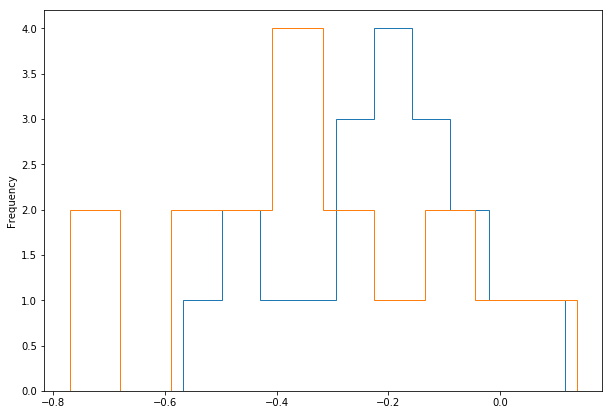

In [231]:
#cols = Red_columns+['batch_number']
data_reduced['LA']['ALL']['data'].loc[:,cols].groupby('batch_number').median().mean(axis=1).plot.hist(histtype='step', label='LA', figsize=(10,7))
data_reduced['LSCC']['ALL']['data'].loc[:,cols].groupby('batch_number').median().mean(axis=1).plot.hist(histtype='step', label='LSCC')